# Setup & Imports

In [1]:
# 0. Imports and basic config

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping


# Paths

In [2]:
# 1. Paths and config

DATA_DIR = r"D:\Work\November\26 Nov\job 1\dataset"   # <-- change this to your folder
FILE_PATTERN = os.path.join(DATA_DIR, "*.xlsx")

EARLY_CYCLE_MAX = 20   # how many early cycles to use as input
TEST_SIZE = 0.2
VAL_SIZE = 0.2
RANDOM_STATE = 42


# Helper: Load One File and Clean Columns

In [3]:
def load_battery_file(filepath):
    """
    Load a single Excel file and return a cleaned DataFrame
    with an added battery_id column.
    """
    df = pd.read_excel(filepath)
    
    # Ensure columns are exactly as expected (rename if needed)
    expected_cols = [
        "Data_Point", "Test_Time(s)", "Current(A)", "Capacity(Ah)",
        "Voltage(V)", "Energy(Wh)", "Temperature(℃)", "Date_Time", "Cycle_Index"
    ]
    
    # Optional: check and adapt if names slightly differ
    # For now, assume they match
    
    # Add battery_id from filename
    battery_id = os.path.splitext(os.path.basename(filepath))[0]
    df["battery_id"] = battery_id
    
    return df


# Load All Files and Concatenate

In [4]:
import os
import glob
import pandas as pd

DATA_DIR = r"D:\Work\November\26 Nov\job 1\dataset"
FILE_PATTERN = os.path.join(DATA_DIR, "*.xlsx")

all_files = [f for f in glob.glob(FILE_PATTERN)
             if not os.path.basename(f).startswith("~$")]

print("Loaded files:", all_files)

def load_battery_file(filepath):
    df = pd.read_excel(filepath)
    df["battery_id"] = os.path.splitext(os.path.basename(filepath))[0]
    return df

df_list = [load_battery_file(f) for f in all_files]
full_df = pd.concat(df_list, ignore_index=True)
full_df.head()


Loaded files: ['D:\\Work\\November\\26 Nov\\job 1\\dataset\\LR1865SZ_cycles201228_001_1.xlsx', 'D:\\Work\\November\\26 Nov\\job 1\\dataset\\LR1865SZ_cycles210109_001_1.xlsx', 'D:\\Work\\November\\26 Nov\\job 1\\dataset\\LR1865SZ_cycles210121_001_1.xlsx', 'D:\\Work\\November\\26 Nov\\job 1\\dataset\\LR1865SZ_cycles210121_001_2.xlsx']


,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Temperature(℃),Date_Time,Cycle_Index,battery_id
0,1,00:00:00,0.0,0.0,4.1887,0.0,26.74,2020-12-28 14:47:00,1,LR1865SZ_cycles201228_001_1
1,2,00:00:01,0.0,0.0,4.1887,0.0,26.74,2020-12-28 14:47:02,1,LR1865SZ_cycles201228_001_1
2,3,00:00:02,0.0,0.0,4.1887,0.0,26.74,2020-12-28 14:47:03,1,LR1865SZ_cycles201228_001_1
3,4,00:00:03,0.0,0.0,4.1887,0.0,26.74,2020-12-28 14:47:04,1,LR1865SZ_cycles201228_001_1
4,5,00:00:05,0.0,0.0,4.1881,0.0,26.74,2020-12-28 14:47:05,1,LR1865SZ_cycles201228_001_1


# Build Cycle-Level Features

In [14]:
def build_cycle_features(full_df):
    grouped = full_df.groupby(["battery_id", "Cycle_Index"])
    features = grouped.agg({
        "Current(A)": ["mean", "max", "min"],
        "Capacity(Ah)": ["last", "max"],
        "Voltage(V)": ["mean", "max", "min"],
        "Energy(Wh)": ["mean"],
        "Temperature(℃)": ["mean", "max"]
    })
    features.columns = ["_".join(col).strip() for col in features.columns]
    return features.reset_index()

cycle_df = build_cycle_features(full_df)
cycle_df.head()


,battery_id,Cycle_Index,Current(A)_mean,Current(A)_max,Current(A)_min,Capacity(Ah)_last,Capacity(Ah)_max,Voltage(V)_mean,Voltage(V)_max,Voltage(V)_min,Energy(Wh)_mean,Temperature(℃)_mean,Temperature(℃)_max
0,LR1865SZ_cycles201228_001_1,1,-4.697573,0.000,-7.212,2.252,2.252,3.611645,4.1899,3.0001,4.022060,34.669455,43.14
1,LR1865SZ_cycles201228_001_1,2,-0.022133,4.809,-7.209,1.699,1.699,3.761866,4.2005,3.0001,3.872848,33.203625,41.32
2,LR1865SZ_cycles201228_001_1,3,-0.008003,4.809,-7.212,1.680,1.684,3.760497,4.2001,3.0001,3.863702,33.083700,41.93
3,LR1865SZ_cycles201228_001_1,4,-0.037121,4.809,-7.212,1.665,1.672,3.758351,4.2001,3.0001,3.847844,33.121772,41.32
4,LR1865SZ_cycles201228_001_1,5,-0.004399,4.809,-7.212,1.651,1.657,3.760258,4.2001,2.9998,3.819075,33.028073,41.32


# Build Categorical Life Label (Short / Medium / Long)

In [20]:
def build_targets_from_capacity(cycle_df, cap_ratio=0.8):
    """
    EoL is defined as the first cycle where capacity <= cap_ratio * initial capacity.
    If no such cycle exists, use max Cycle_Index.
    Returns: battery_id, target_EOL_cycle
    """
    rows = []

    for bid, grp in cycle_df.groupby("battery_id"):
        grp = grp.sort_values("Cycle_Index")

        # initial capacity = first cycle's capacity
        initial_cap = grp["Capacity(Ah)_last"].iloc[0]
        threshold = cap_ratio * initial_cap

        # find first cycle where capacity <= threshold
        eol_cycles = grp.loc[grp["Capacity(Ah)_last"] <= threshold, "Cycle_Index"]

        if len(eol_cycles) > 0:
            eol_cycle = int(eol_cycles.iloc[0])
        else:
            # fallback: use last recorded cycle
            eol_cycle = int(grp["Cycle_Index"].max())

        rows.append({"battery_id": bid, "target_EOL_cycle": eol_cycle})

    target_df = pd.DataFrame(rows)
    return target_df

target_df = build_targets_from_capacity(cycle_df, cap_ratio=0.8)
print(target_df)


                    battery_id  target_EOL_cycle
0  LR1865SZ_cycles201228_001_1                 2
1  LR1865SZ_cycles210109_001_1                 2
2  LR1865SZ_cycles210121_001_1                12
3  LR1865SZ_cycles210121_001_2                12


# Create Early-Cycle Sequences

In [21]:
import numpy as np
import pandas as pd

def add_life_classes(target_df, n_classes=3):
    """
    Add a categorical 'life_class' column based on quantiles of target_EOL_cycle.
    """
    if len(target_df) < n_classes:
        print("⚠ Not enough batteries for", n_classes, "classes. Using 2 classes instead.")
        n_classes = 2

    if target_df["target_EOL_cycle"].nunique() == 1:
        print("⚠ All batteries still have identical EoL cycles. Only one class possible.")
        target_df["life_class"] = 0
        return target_df

    quantiles = np.linspace(0, 1, n_classes + 1)
    q_values = target_df["target_EOL_cycle"].quantile(quantiles).values

    # ensure strictly increasing
    for i in range(1, len(q_values)):
        if q_values[i] <= q_values[i-1]:
            q_values[i] = q_values[i-1] + 1e-6

    bins = q_values
    labels = list(range(n_classes))

    target_df["life_class"] = pd.cut(
        target_df["target_EOL_cycle"],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype(int)

    return target_df

target_df = add_life_classes(target_df, n_classes=3)
print(target_df)


                    battery_id  target_EOL_cycle  life_class
0  LR1865SZ_cycles201228_001_1                 2           0
1  LR1865SZ_cycles210109_001_1                 2           0
2  LR1865SZ_cycles210121_001_1                12           2
3  LR1865SZ_cycles210121_001_2                12           2


In [22]:
EARLY_CYCLE_MAX = 20

def create_sequences_categorical(cycle_df, target_df, early_cycle_max):
    merged = cycle_df.merge(target_df, on="battery_id", how="inner")

    X_list, y_list, ids = [], [], []

    drop_cols = ["battery_id", "Cycle_Index", "target_EOL_cycle", "life_class"]
    feature_cols = [c for c in merged.columns if c not in drop_cols]

    for bid, sub in merged.groupby("battery_id"):
        sub = sub.sort_values("Cycle_Index")

        early = sub[sub["Cycle_Index"] <= early_cycle_max]
        if early.shape[0] < early_cycle_max:
            continue

        X_list.append(early[feature_cols].values)
        y_list.append(int(early["life_class"].iloc[0]))
        ids.append(bid)

    X = np.array(X_list)
    y = np.array(y_list, dtype=int)
    ids = np.array(ids)

    return X, y, ids, feature_cols

X, y, battery_ids, feature_cols = create_sequences_categorical(
    cycle_df, target_df, EARLY_CYCLE_MAX
)

print("X:", X.shape)
print("y:", y)
print("Classes:", np.unique(y))


X: (4, 20, 11)
y: [0 0 2 2]
Classes: [0 2]


# Train/Validation/Test Split

In [23]:
import numpy as np

EARLY_CYCLE_MAX = 2  # use first 2 cycles as input for all batteries

def create_early_cycle_sequences(cycle_df, target_df, early_cycle_max):
    """
    Create early-cycle sequences (X) and categorical labels (y) per battery.
    
    X shape: (num_batteries, early_cycle_max, num_features)
    y shape: (num_batteries,)  -> life_class (int)
    """
    # Merge cycle-level features with target labels
    merged = cycle_df.merge(target_df, on="battery_id", how="inner")
    
    X_list = []
    y_list = []
    battery_ids = []
    
    # Features = all numeric columns except IDs and targets
    drop_cols = ["battery_id", "Cycle_Index", "target_EOL_cycle", "life_class"]
    feature_cols = [c for c in merged.columns if c not in drop_cols]
    
    for bid, sub in merged.groupby("battery_id"):
        # sort by cycle index to keep temporal order
        sub = sub.sort_values("Cycle_Index")
        
        # select early cycles only
        early = sub[sub["Cycle_Index"] <= early_cycle_max]
        
        # if a battery has fewer cycles than early_cycle_max, skip it
        if early.shape[0] < early_cycle_max:
            print(f"Skipping {bid}: only {early.shape[0]} cycles available.")
            continue
        
        # sequence of shape (early_cycle_max, num_features)
        seq = early[feature_cols].values
        
        X_list.append(seq)
        y_list.append(int(early["life_class"].iloc[0]))  # same class for all cycles of that battery
        battery_ids.append(bid)
    
    if len(X_list) == 0:
        raise ValueError("No batteries had enough early cycles. Reduce EARLY_CYCLE_MAX.")
    
    X = np.array(X_list)
    y = np.array(y_list, dtype=int)
    battery_ids = np.array(battery_ids)
    
    return X, y, battery_ids, feature_cols

X, y, battery_ids, feature_cols = create_early_cycle_sequences(
    cycle_df, target_df, EARLY_CYCLE_MAX
)

print("X shape:", X.shape)           # (num_batteries, early_cycle_max, num_features)
print("y:", y)                       # class labels
print("battery_ids:", battery_ids)   # which batteries used
print("Classes in y:", np.unique(y))
print("Num features:", len(feature_cols))


X shape: (4, 2, 11)
y: [0 0 2 2]
battery_ids: ['LR1865SZ_cycles201228_001_1' 'LR1865SZ_cycles210109_001_1'
 'LR1865SZ_cycles210121_001_1' 'LR1865SZ_cycles210121_001_2']
Classes in y: [0 2]
Num features: 11


# STEP 6 — Feature Scaling (same scaler over all timesteps)

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

# 5.0 Remap classes from [0,2] -> [0,1]
unique_classes = np.unique(y)
class_to_idx = {c: i for i, c in enumerate(unique_classes)}
print("Class mapping:", class_to_idx)

y_enc = np.array([class_to_idx[c] for c in y])  # encoded labels

print("Original y:", y)
print("Encoded y:", y_enc)
print("Encoded classes:", np.unique(y_enc))

# 5.1 Train/Val/Test split
n_samples = X.shape[0]
print("Total samples (batteries):", n_samples)

if n_samples >= 8:
    # Normal case (for larger dataset)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, shuffle=True, stratify=y_enc
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, shuffle=True, stratify=y_train
    )
else:
    # Small dataset fallback: use everything for all splits
    print("⚠ Not enough batteries for a proper split. Using all data for train/val/test.")
    X_train, y_train = X, y_enc
    X_val,   y_val   = X, y_enc
    X_test,  y_test  = X, y_enc

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape,   y_val.shape)
print("Test shape: ", X_test.shape,  y_test.shape)


Class mapping: {0: 0, 2: 1}
Original y: [0 0 2 2]
Encoded y: [0 0 1 1]
Encoded classes: [0 1]
Total samples (batteries): 4
⚠ Not enough batteries for a proper split. Using all data for train/val/test.
Train shape: (4, 2, 11) (4,)
Val shape:   (4, 2, 11) (4,)
Test shape:  (4, 2, 11) (4,)


In [25]:
from sklearn.preprocessing import StandardScaler

# Shapes
num_train, T, F = X_train.shape
num_val  = X_val.shape[0]
num_test = X_test.shape[0]

scaler = StandardScaler()

# Flatten time dimension
X_train_flat = X_train.reshape(-1, F)
X_val_flat   = X_val.reshape(-1, F)
X_test_flat  = X_test.reshape(-1, F)

# Fit on train only
scaler.fit(X_train_flat)

# Transform
X_train_scaled = scaler.transform(X_train_flat).reshape(num_train, T, F)
X_val_scaled   = scaler.transform(X_val_flat).reshape(num_val,   T, F)
X_test_scaled  = scaler.transform(X_test_flat).reshape(num_test, T, F)

X_train = X_train_scaled
X_val   = X_val_scaled
X_test  = X_test_scaled

print("Scaled shapes:", X_train.shape, X_val.shape, X_test.shape)


Scaled shapes: (4, 2, 11) (4, 2, 11) (4, 2, 11)


# STEP 7 — Build & Train LSTM Classifier

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(np.unique(y_enc))
print("Number of classes:", num_classes)

def build_lstm_classifier(timesteps, num_features, num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(timesteps, num_features)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))  # classification
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model

T = X_train.shape[1]
F = X_train.shape[2]

model = build_lstm_classifier(T, F, num_classes)
model.summary()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=2,
    callbacks=[early_stop],
    verbose=1
)


Number of classes: 2


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 2, 11)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,602 (84.38 KB)

 Trainable params: 21,602 (84.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.5000 - loss: 0.7277 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2500 - loss: 0.7016 - val_accuracy: 0.7500 - val_loss: 0.6676
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.6457 - val_accuracy: 1.0000 - val_loss: 0.6440
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7500 - loss: 0.6438 - val_accuracy: 1.0000 - val_loss: 0.6214
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.5799 - val_accuracy: 1.0000 - val_loss: 0.5986
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.5927 - val_accuracy: 1.0000 - val_loss: 0.5752
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.5731 - val_accuracy: 1.0000 - val_loss: 0.5515
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.5521 - val_accuracy: 1.0000 - val_loss

# Evaluate Model on Test Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Encoded test labels: [0 0 1 1]
Encoded preds: [0 0 1 1]
Original test labels: [0 0 2 2]
Original preds: [0 0 2 2]

Test Accuracy: 1.000

Classification report (encoded labels):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Confusion matrix (encoded labels):
[[2 0]
 [0 2]]


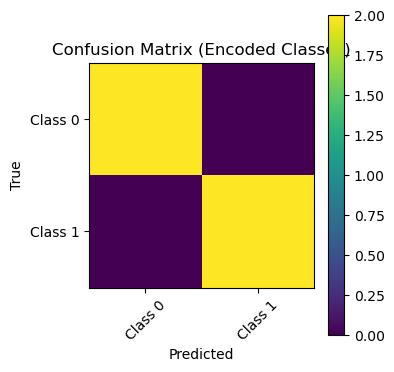

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict probabilities then class indices
y_proba = model.predict(X_test)
y_pred_enc = np.argmax(y_proba, axis=1)

# Map back to original labels (0 / 2) if you want
idx_to_class = {v: k for k, v in class_to_idx.items()}
y_test_orig = np.array([idx_to_class[i] for i in y_test])
y_pred_orig = np.array([idx_to_class[i] for i in y_pred_enc])

print("Encoded test labels:", y_test)
print("Encoded preds:", y_pred_enc)
print("Original test labels:", y_test_orig)
print("Original preds:", y_pred_orig)

acc = accuracy_score(y_test, y_pred_enc)
print(f"\nTest Accuracy: {acc:.3f}")

print("\nClassification report (encoded labels):")
print(classification_report(y_test, y_pred_enc))

print("Confusion matrix (encoded labels):")
print(confusion_matrix(y_test, y_pred_enc))

# Simple confusion matrix heatmap
plt.figure(figsize=(4, 4))
cm = confusion_matrix(y_test, y_pred_enc)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Encoded Classes)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [f"Class {i}" for i in range(num_classes)], rotation=45)
plt.yticks(tick_marks, [f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
